<a href="https://colab.research.google.com/github/Preeti-ing/Stock-Price-Prediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/sample_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/sample_data/fundamentals.csv
/content/sample_data/prices.csv
/content/sample_data/prices-split-adjusted.csv
/content/sample_data/securities.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import math, time

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, LSTM, GRU
from tensorflow.keras.optimizers import Adam,RMSprop,SGD

In [ ]:
stocks_df = pd.read_csv("/content/sample_data/prices-split-adjusted.csv",index_col=0)
firm_df = pd.read_csv("/content/sample_data/securities.csv",header=0)

In [ ]:
stocks_df.head(10)

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0


In [ ]:
firm_df.head(10)

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877
5,AYI,Acuity Brands Inc,reports,Industrials,Electrical Components & Equipment,"Atlanta, Georgia",2016-05-03,1144215
6,ADBE,Adobe Systems Inc,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343
7,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,1158449
8,AES,AES Corp,reports,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",NaN,874761
9,AET,Aetna Inc,reports,Health Care,Managed Health Care,"Hartford, Connecticut",1976-06-30,1122304


In [ ]:
stocks_df.isnull().sum()

symbol    0
open      0
close     0
low       0
high      0
volume    1
dtype: int64

In [ ]:
firm_df.isnull().sum()

Ticker symbol                0
Security                     0
SEC filings                  0
GICS Sector                  0
GICS Sub Industry            0
Address of Headquarters      0
Date first added           198
CIK                          0
dtype: int64

In [ ]:
symbols = list(set(stocks_df.symbol))
len(symbols)

471

In [ ]:
symbols[:10]

['ETFC', 'MCK', 'WHR', 'WMT', 'NUE', 'RTN', 'VFC', 'ADI', 'KSS', 'MRK']

In [ ]:
firm_df.loc[firm_df.Security.str.startswith('Micro'),:]

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
304,MCHP,Microchip Technology,reports,Information Technology,Semiconductors,"Chandler, Arizona",2007-09-07,827054
305,MU,Micron Technology,reports,Information Technology,Semiconductors,"Boise, Idaho",1994-09-27,723125
306,MSFT,Microsoft Corp.,reports,Information Technology,Systems Software,"Redmond, Washington",1994-06-01,789019


In [ ]:
stocks_msft = stocks_df[stocks_df.symbol == 'MSFT']

In [ ]:
stocks_msft.head(10)

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
2010-01-06,MSFT,30.879999,30.770000,30.520000,31.080000,58182400.0
2010-01-07,MSFT,30.629999,30.450001,30.190001,30.700001,50559700.0
2010-01-08,MSFT,30.280001,30.660000,30.240000,30.879999,51197400.0
2010-01-11,MSFT,30.709999,30.270000,30.120001,30.760000,68754700.0
2010-01-12,MSFT,30.150000,30.070000,29.910000,30.400000,65912100.0
2010-01-13,MSFT,30.260000,30.350000,30.010000,30.520000,51863500.0
2010-01-14,MSFT,30.309999,30.959999,30.260000,31.100000,63228100.0


In [ ]:
stocks_msft.shape

(725, 6)

Text(0, 0.5, 'prices')

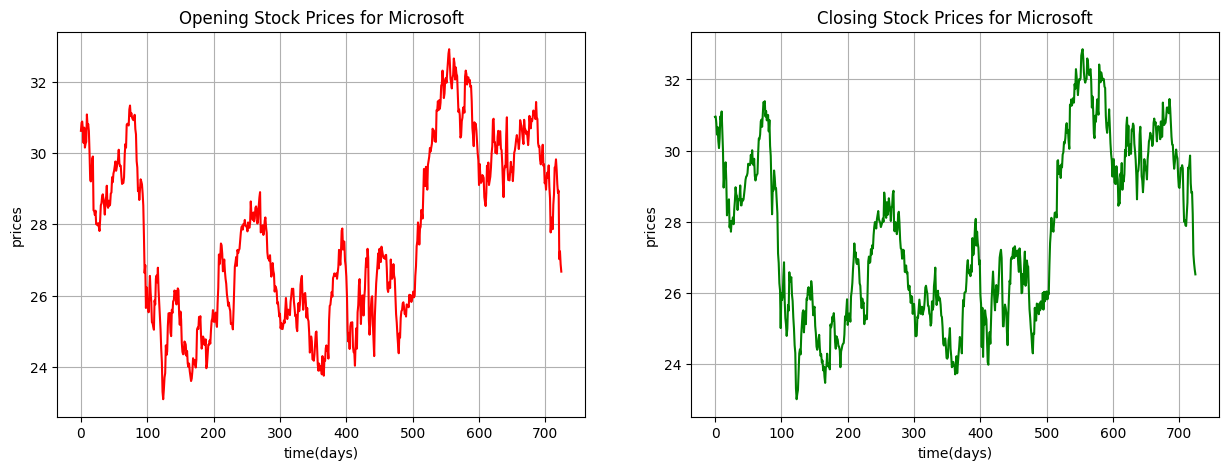

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(stocks_msft.open.values.astype('float32'),color='red',label=open)
plt.title('Opening Stock Prices for Microsoft')
plt.grid(True)
plt.xlabel('time(days)')
plt.ylabel('prices')

plt.subplot(1,2,2)
plt.plot(stocks_msft.close.values.astype('float32'),color='green',label=open)
plt.title('Closing Stock Prices for Microsoft')
plt.grid(True)
plt.xlabel('time(days)')
plt.ylabel('prices')

Text(0, 0.5, 'Volume')

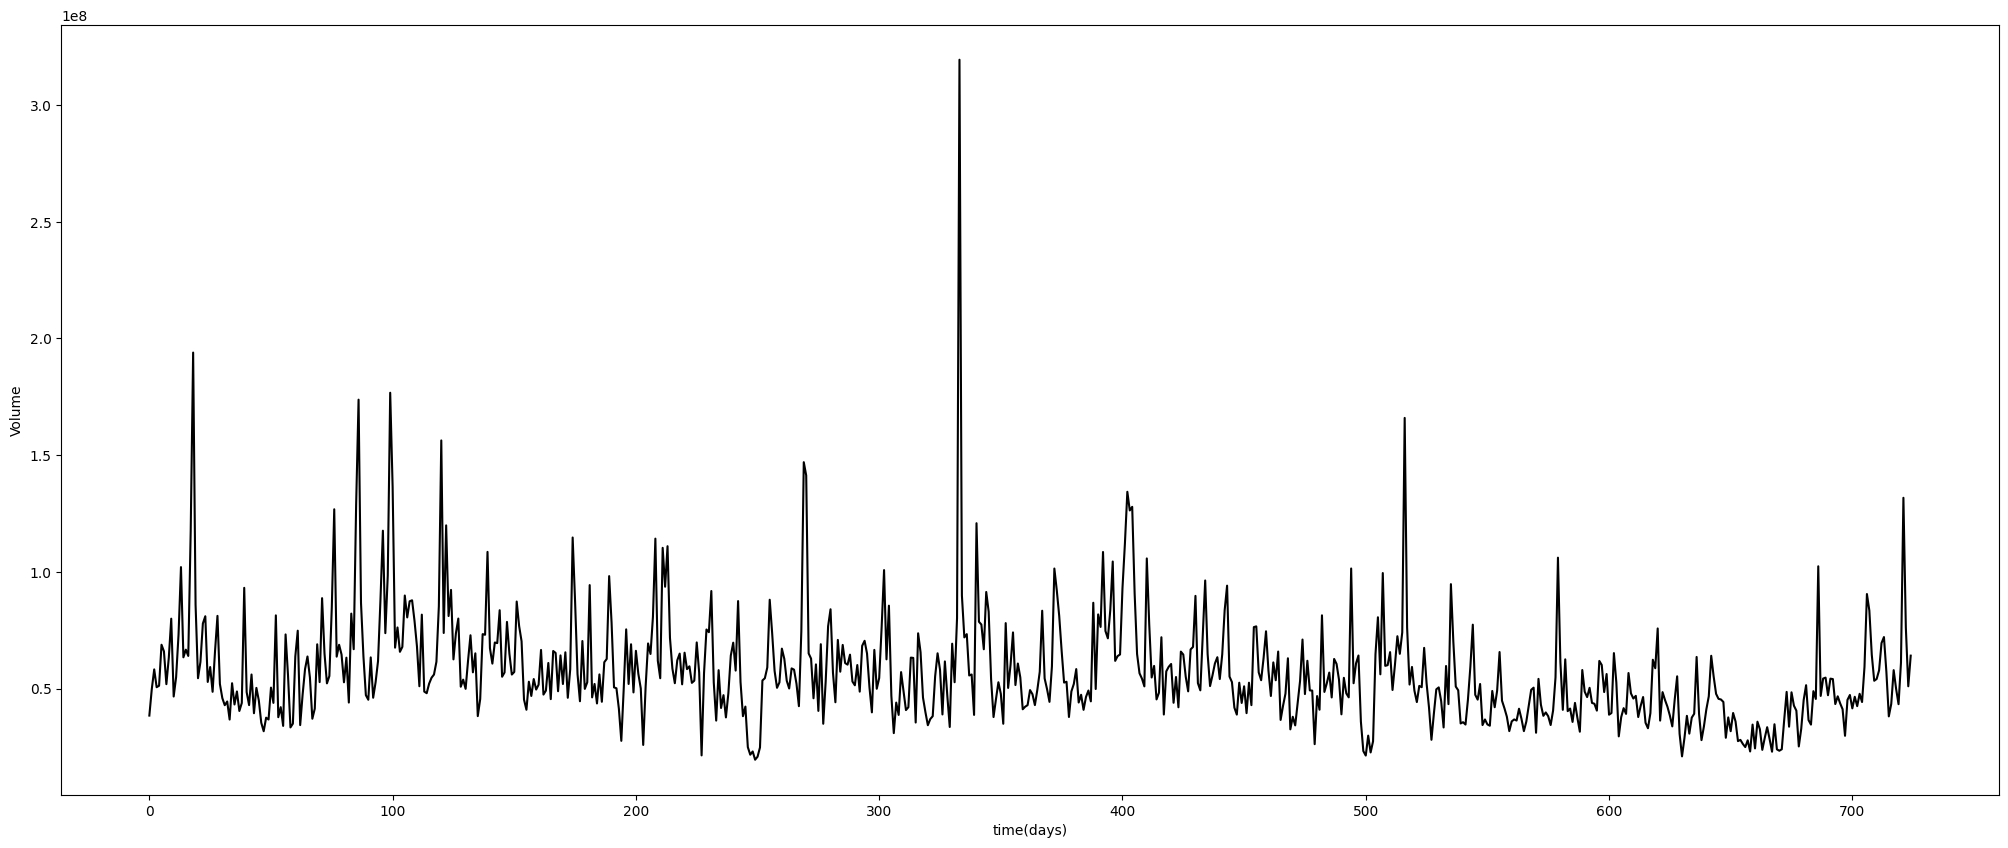

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(stocks_msft.volume.values,color='black')
plt.xlabel('time(days)')
plt.ylabel('Volume')

In [ ]:
np.random.seed(7)

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
msft = stocks_msft.copy()
#msft = msft.drop('symbol',axis=1)
closing = msft.close.values
closing = closing.reshape(len(closing),1)

#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
closing = scaler.fit_transform(closing)

In [ ]:
# split into train and test sets
train_size = int(len(closing) * 0.75)
test_size = len(closing) - train_size

In [ ]:
print(train_size , test_size)

543 182


In [ ]:
train, test = closing[0:train_size,:], closing[train_size:len(closing),:]

In [ ]:
print(train)
print("\n ----------------------------")
print(test)

[[0.80691083]
 [0.80792689]
 [0.78861805]
 [0.75609782]
 [0.77743918]
 [0.73780503]
 [0.71747982]
 [0.74593511]
 [0.80792689]
 [0.79776449]
 [0.82215464]
 [0.77032536]
 [0.71138226]
 [0.60467482]
 [0.64126029]
 [0.65955298]
 [0.67682941]
 [0.62500013]
 [0.52540661]
 [0.5487806 ]
 [0.5538618 ]
 [0.57113823]
 [0.49085376]
 [0.50914644]
 [0.47865853]
 [0.50813018]
 [0.50609766]
 [0.51930915]
 [0.5000001 ]
 [0.54268304]
 [0.56707329]
 [0.60569108]
 [0.58536597]
 [0.58130093]
 [0.54065052]
 [0.57113823]
 [0.56808955]
 [0.57520337]
 [0.61077248]
 [0.5538618 ]
 [0.5538618 ]
 [0.57113823]
 [0.56707329]
 [0.57113823]
 [0.58841465]
 [0.60569108]
 [0.62703265]
 [0.63617899]
 [0.63821161]
 [0.6463417 ]
 [0.67276426]
 [0.67073195]
 [0.66869932]
 [0.66971558]
 [0.69817077]
 [0.67479689]
 [0.71138226]
 [0.67581315]
 [0.66869932]
 [0.68699201]
 [0.63821161]
 [0.62500013]
 [0.63617899]
 [0.64126029]
 [0.64430907]
 [0.70223592]
 [0.74491885]
 [0.74288633]
 [0.75609782]
 [0.79369935]
 [0.79878075]
 [0.77

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1   # Taking 1 past values to predict a single value
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((541, 1, 1), (541,), (180, 1, 1), (180,))

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.95):
            print("\n Reaching 95% so stopping the training now")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
filepath = 'weights'
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor = 'val_accuracy', verbose=0, save_freq='epoch',save_best_only=True)

In [ ]:
lr_platue = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=5,verbose=0,mode='max')

In [ ]:
def build_model():

    model = Sequential()

    model.add(LSTM(256, input_shape=(1, look_back), return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(256))
    model.add(Dropout(0.4))

    model.add(Dense(64,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))


    start = time.time()
    model.compile(loss='mse',optimizer=Adam(lr = 0.0005), metrics=['mean_squared_error'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
model = build_model()
history = model.fit(trainX,trainY,epochs=100,batch_size=128,
                   callbacks = [lr_platue,modelcheckpoint], validation_data = (testX,testY))

Compilation Time :  0.021702289581298828
Epoch 1/100
3/5 [=================>............] - ETA: 0s - loss: 0.1885 - mean_squared_error: 0.1885 

5/5 [==============================] - 8s 277ms/step - loss: 0.1822 - mean_squared_error: 0.1822 - val_loss: 0.5471 - val_mean_squared_error: 0.5471 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1703 - mean_squared_error: 0.1703

5/5 [==============================] - 0s 44ms/step - loss: 0.1703 - mean_squared_error: 0.1703 - val_loss: 0.5091 - val_mean_squared_error: 0.5091 - lr: 0.0010
Epoch 3/100
3/5 [=================>............] - ETA: 0s - loss: 0.1538 - mean_squared_error: 0.1538

5/5 [==============================] - 0s 36ms/step - loss: 0.1504 - mean_squared_error: 0.1504 - val_loss: 0.4382 - val_mean_squared_error: 0.4382 - lr: 0.0010
Epoch 4/100
3/5 [=================>............] - ETA: 0s - loss: 0.1259 - mean_squared_error: 0.1259

5/5 [==============================] - 0s 37ms/step - loss: 0.1169 - mean_squared_error: 0.1169 - val_loss: 0.3159 - val_mean_squared_error: 0.3159 - lr: 0.0010
Epoch 5/100
3/5 [=================>............] - ETA: 0s - loss: 0.0726 - mean_squared_error: 0.0726

5/5 [==============================] - 0s 39ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.1423 - val_mean_squared_error: 0.1423 - lr: 0.0010
Epoch 6/100
3/5 [=================>............] - ETA: 0s - loss: 0.0274 - mean_squared_error: 0.0274

5/5 [==============================] - 0s 38ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - lr: 0.0010
Epoch 7/100
3/5 [=================>............] - ETA: 0s - loss: 0.0299 - mean_squared_error: 0.0299

5/5 [==============================] - 0s 36ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - lr: 0.0010
Epoch 8/100
3/5 [=================>............] - ETA: 0s - loss: 0.0230 - mean_squared_error: 0.0230

5/5 [==============================] - 0s 39ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - lr: 0.0010
Epoch 9/100
3/5 [=================>............] - ETA: 0s - loss: 0.0175 - mean_squared_error: 0.0175

5/5 [==============================] - 0s 38ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0772 - val_mean_squared_error: 0.0772 - lr: 0.0010
Epoch 10/100
3/5 [=================>............] - ETA: 0s - loss: 0.0188 - mean_squared_error: 0.0188

5/5 [==============================] - 0s 38ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0561 - val_mean_squared_error: 0.0561 - lr: 0.0010
Epoch 11/100
3/5 [=================>............] - ETA: 0s - loss: 0.0148 - mean_squared_error: 0.0148

5/5 [==============================] - 0s 38ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - lr: 0.0010
Epoch 12/100
3/5 [=================>............] - ETA: 0s - loss: 0.0129 - mean_squared_error: 0.0129

5/5 [==============================] - 0s 39ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - lr: 0.0010
Epoch 13/100
5/5 [==============================] - ETA: 0s - loss: 0.0120 - mean_squared_error: 0.0120

5/5 [==============================] - 0s 42ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - lr: 0.0010
Epoch 14/100
3/5 [=================>............] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.0109

5/5 [==============================] - 0s 40ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - lr: 0.0010
Epoch 15/100
3/5 [=================>............] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

5/5 [==============================] - 0s 38ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - lr: 0.0010
Epoch 16/100
3/5 [=================>............] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

5/5 [==============================] - 0s 37ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - lr: 0.0010
Epoch 17/100
3/5 [=================>............] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

5/5 [==============================] - 0s 36ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - lr: 0.0010
Epoch 18/100
5/5 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

5/5 [==============================] - 0s 53ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - lr: 0.0010
Epoch 19/100
3/5 [=================>............] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

5/5 [==============================] - 0s 36ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - lr: 0.0010
Epoch 20/100
3/5 [=================>............] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

5/5 [==============================] - 0s 37ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.0010
Epoch 21/100
3/5 [=================>............] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

5/5 [==============================] - 0s 38ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 22/100
3/5 [=================>............] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 39ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 23/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 40ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 24/100
3/5 [=================>............] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 39ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - lr: 0.0010
Epoch 25/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 37ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - lr: 0.0010
Epoch 26/100
3/5 [=================>............] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 40ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - lr: 0.0010
Epoch 27/100
3/5 [=================>............] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

5/5 [==============================] - 0s 38ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 0.0010
Epoch 28/100
3/5 [=================>............] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 38ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 29/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 43ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 0.0010
Epoch 30/100
3/5 [=================>............] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 40ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - lr: 0.0010
Epoch 31/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 36ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 32/100
3/5 [=================>............] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

5/5 [==============================] - 0s 38ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 33/100
3/5 [=================>............] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

5/5 [==============================] - 0s 38ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - lr: 0.0010
Epoch 34/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 51ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 35/100
3/5 [=================>............] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 36ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 36/100
4/5 [=======================>......] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 81ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 0.0010
Epoch 37/100
4/5 [=======================>......] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 79ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 38/100
3/5 [=================>............] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 41ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 39/100
3/5 [=================>............] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

5/5 [==============================] - 0s 38ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 0.0010
Epoch 40/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 37ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 41/100
3/5 [=================>............] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 37ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 42/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 43ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 0.0010
Epoch 43/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 45ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 44/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 57ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 45/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 66ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 0.0010
Epoch 46/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 58ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 47/100
4/5 [=======================>......] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 61ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 48/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 67ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - lr: 0.0010
Epoch 49/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 64ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 50/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 60ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 51/100
5/5 [==============================] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 56ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - lr: 0.0010
Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 64ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 64ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 64ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 65ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

5/5 [==============================] - 0s 54ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 57/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 39ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 58/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 43ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 59/100
3/5 [=================>............] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 38ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 60/100
3/5 [=================>............] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

5/5 [==============================] - 0s 39ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 61/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 62/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 38ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 63/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 43ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 64/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 38ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 65/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - lr: 0.0010
Epoch 66/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 39ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 67/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 39ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - lr: 0.0010
Epoch 68/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 40ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 69/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 70/100
3/5 [=================>............] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 37ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 71/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 39ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 72/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 39ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 73/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 74/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 38ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 75/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 37ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 76/100
3/5 [=================>............] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

5/5 [==============================] - 0s 37ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 77/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 39ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 78/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 36ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 79/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

5/5 [==============================] - 0s 42ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 80/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 36ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 81/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 38ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 82/100
3/5 [=================>............] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019

5/5 [==============================] - 0s 38ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 83/100
3/5 [=================>............] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

5/5 [==============================] - 0s 39ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - lr: 0.0010
Epoch 84/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 39ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 85/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 40ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 86/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 87/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 38ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 88/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 41ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 89/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 90/100
3/5 [=================>............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

5/5 [==============================] - 0s 41ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 91/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 37ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - lr: 0.0010
Epoch 92/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 38ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 0.0010
Epoch 93/100
3/5 [=================>............] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 41ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 94/100
3/5 [=================>............] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.0018

5/5 [==============================] - 0s 38ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 95/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

5/5 [==============================] - 0s 46ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 96/100
3/5 [=================>............] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.0018

5/5 [==============================] - 0s 39ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 97/100
3/5 [=================>............] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019

5/5 [==============================] - 0s 38ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 98/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 39ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 99/100
3/5 [=================>............] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 37ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

5/5 [==============================] - 0s 45ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - lr: 0.0010


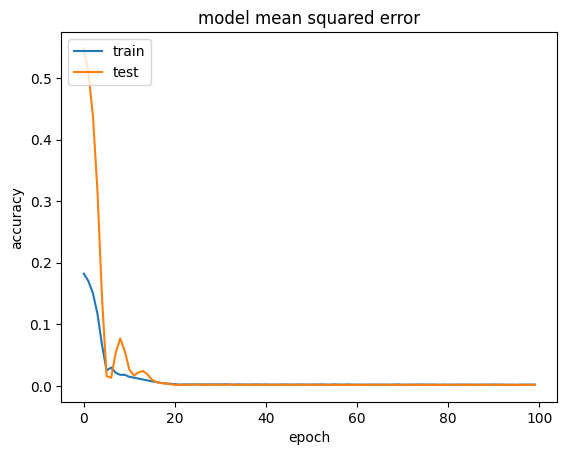

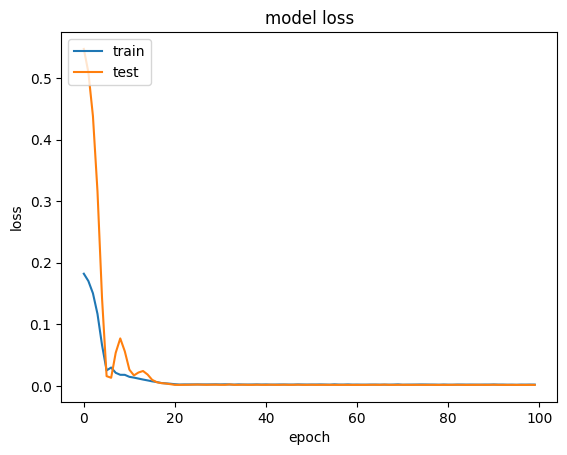

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00147 MSE (0.04 RMSE)
Test Score: 0.00168 MSE (0.04 RMSE)


(0.001466405694372952, 0.0016806831117719412)

In [ ]:
pred = model.predict(testX)
pred = scaler.inverse_transform(pred)

6/6 [==============================] - 1s 8ms/step


In [ ]:
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)

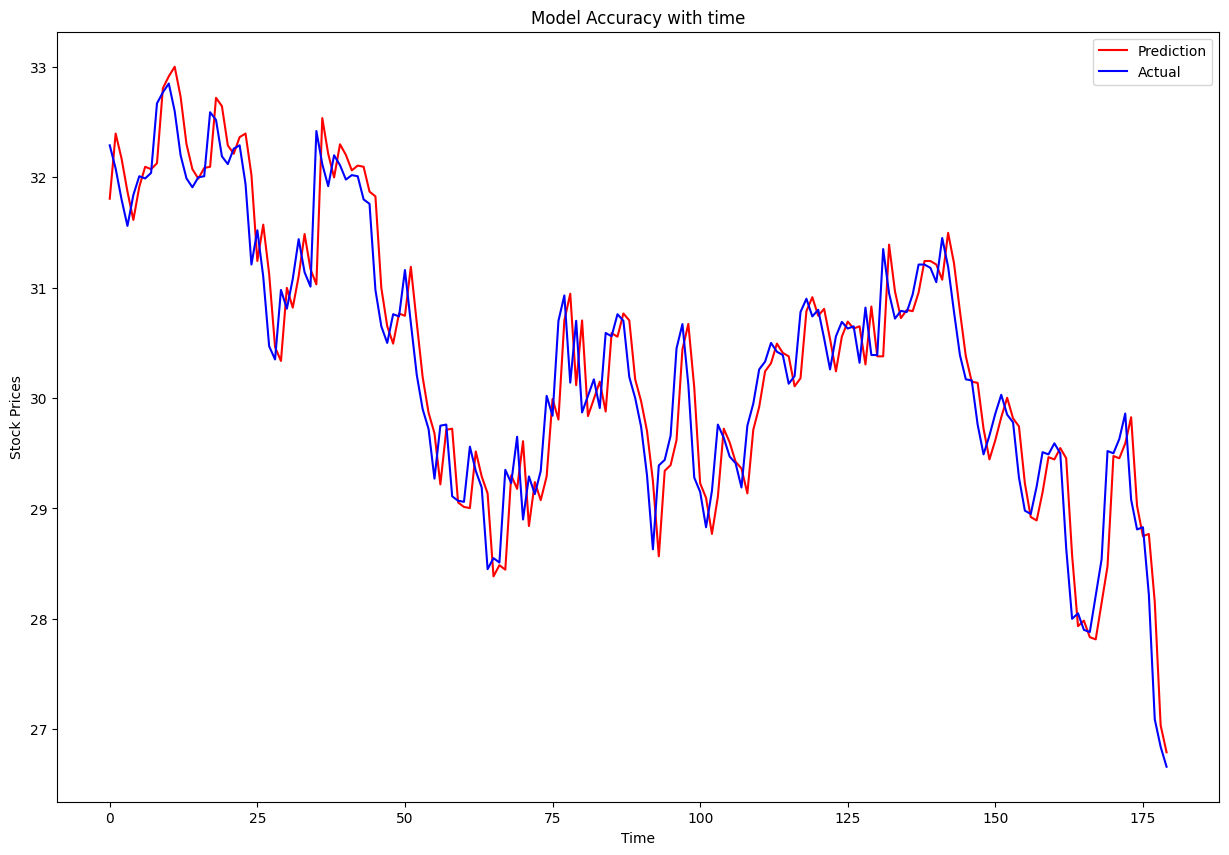

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(pred,color='red', label='Prediction')
plt.plot(testY,color='blue', label='Actual')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Model Accuracy with time')
plt.legend(loc='best')
plt.show()